# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
"""
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
"""   


"\nfor i in range(5):                                         # play game for 5 episodes\n    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \n    states = env_info.vector_observations                  # get the current state (for each agent)\n    scores = np.zeros(num_agents)                          # initialize the score (for each agent)\n    while True:\n        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n        env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n        next_states = env_info.vector_observations         # get next state (for each agent)\n        rewards = env_info.rewards                         # get reward (for each agent)\n        dones = env_info.local_done                        # see if episode finished\n        scores += env_info.rewards               

When finished, you can close the environment.

In [6]:
from collections import deque
import torch
import random

def maddpg(multi_agent, env, n_episodes=2500, max_t=5000, print_every=100, eps_start=1.0, eps_end=0.01, eps_decay=1.0):
    scores_deque = deque(maxlen=print_every)
    scores = []
    avg_scores = []
    eps = eps_start                                                 # initialize epsilon
    add_noise = True
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations                        # get the current state
        multi_agent.reset()
        score = np.zeros(num_agents)                                # initialize the score
        
        for t in range(max_t):
            if random.random() > eps:
                add_noise = False
            else:
                add_noise = True
            action = multi_agent.act(state, add_noise)
            env_info = env.step(action)[brain_name]            # send action to the environment
            next_state = env_info.vector_observations          # get next state (for each agent)
            reward = env_info.rewards                          # get reward (for each agent)
            done = env_info.local_done                         # see if episode finished
            multi_agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break 
        eps = max(eps_end, eps_decay*eps)                      # decrease epsilon        
        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        avg_scores.append(np.mean(scores_deque))
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(multi_agent.agent1.actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
            torch.save(multi_agent.agent1.critic_local.state_dict(), 'agent1_checkpoint_critic.pth')
            torch.save(multi_agent.agent2.actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
            torch.save(multi_agent.agent2.critic_local.state_dict(), 'agent2_checkpoint_critic.pth')            
            break            
            
    return scores, avg_scores


In [7]:
from maddpg_agent import multi_Agent
import matplotlib.pyplot as plt
%matplotlib inline

multi_agent = multi_Agent(state_size, action_size, random_seed=0)

scores, avg_scores = maddpg(multi_agent, env)



 model is model_maddpg_1BN
Episode 100	Average Score: 0.0010
Episode 200	Average Score: 0.0255
Episode 300	Average Score: 0.0149
Episode 400	Average Score: 0.0412
Episode 500	Average Score: 0.0276
Episode 600	Average Score: 0.0538
Episode 700	Average Score: 0.0676
Episode 800	Average Score: 0.1290
Episode 900	Average Score: 0.1375
Episode 1000	Average Score: 0.2650
Episode 1100	Average Score: 0.3852
Episode 1200	Average Score: 0.4175
Episode 1300	Average Score: 0.4552
Episode 1353	Average Score: 0.5060
Environment solved in 1353 episodes!	Average Score: 0.5060


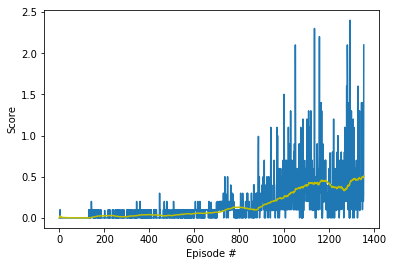

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, c = 'y', label = 'Average max scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [9]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 